In [1]:
from U_net import *
import os, gzip
import matplotlib.pyplot as plt
import constants
import pandas as pd
import time
from torch.utils.data import DataLoader
import torch
import gc
import voc
import torchvision.transforms as standard_transforms
import util
import numpy as np
import sys
import math
import copy

class MaskToTensor(object):
    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.int32)).long()

# Initialize Weights with Xavier Weight Initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.normal_(m.bias.data) #xavier not applicable for biases

In [2]:
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
target_transform = MaskToTensor()

train_dataset =voc.VOC('train', transform=input_transform, target_transform=target_transform)
val_dataset = voc.VOC('val', transform=input_transform, target_transform=target_transform)
test_dataset = voc.VOC('test', transform=input_transform, target_transform=target_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size= 8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 8, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size= 8, shuffle=False)

epochs = 20
n_class = 21

fcn_model = U_net(n_class=n_class)
fcn_model.apply(init_weights)

U_net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn7): BatchNorm2d

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

optimizer = torch.optim.Adam(fcn_model.parameters(), lr=5e-4)

# Choose an appropriate loss function from https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html
criterion = nn.CrossEntropyLoss()
fcn_model = fcn_model.to(device)
max_model = fcn_model

earlystop = 5

trainEpochLoss = []
trainEpochAccuracy = [] 
valEpochLoss = []
valEpochAccuracy = [] 

In [4]:
def train():
    """
    Train a deep learning model using mini-batches.

    - Perform forward propagation in each epoch.
    - Compute loss and conduct backpropagation.
    - Update model weights.
    - Evaluate model on validation set for mIoU score.
    - Save model state if mIoU score improves.
    - Implement early stopping if necessary.

    Returns:
        None.
    """

    patience = 0
    best_iou_score = 0.0

    for epoch in range(epochs):
        ts = time.time()
        losses = []
        accuracy = []
        for iter, (inputs, labels) in enumerate(train_loader):
            
            optimizer.zero_grad() # reset optimizer gradients

            inputs, labels = inputs.to(device), labels.to(device) # both inputs and labels in device as model

            outputs = fcn_model(inputs) #  Compute outputs. Automatically in the same device as the model's
            N, numClass, H, W = outputs.shape

            prediction = outputs.reshape(N, n_class, -1).argmax(dim=1).view(N, H, W)
            acc = util.pixel_acc(prediction, labels) # Calculate pixel accuracy
            accuracy.append(acc)

            loss = criterion(outputs, labels) #Calculate loss

            loss.backward() # Bckpropagate model

            optimizer.step() # Update the weights
            
            losses.append(loss.item())

            #if iter % 10 == 0:
            #    print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))
        
        currentEpochLoss = np.mean(losses)
        trainEpochLoss.append(currentEpochLoss)

        currentEpochAccuracy = np.mean(accuracy)
        trainEpochAccuracy.append(currentEpochAccuracy)

        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        print("Train Avg Loss: {}".format(currentEpochLoss))
        print("Train Avg Accuracy: {}".format(currentEpochAccuracy))

        current_miou_score = val(epoch)

        # Save current IoU if better than stored best
        if current_miou_score > best_iou_score:
            best_iou_score = current_miou_score
            patience = 0
            max_model = copy.deepcopy(fcn_model) # save the best model
        else:
            patience += 1

        print("Best iou score: {}".format(best_iou_score))
            
        # Early stop if patience level is met
        if patience >= earlystop:
            print("Early stop at epoch " + str(epoch))
            break
    

In [5]:
def val(epoch):
    """
    Validate the deep learning model on a validation dataset.

    - Set model to evaluation mode. DONE
    - Disable gradient calculations. DONE
    - Iterate over validation data loader:
        - Perform forward pass to get outputs.
        - Compute loss and accumulate it.
        - Calculate and accumulate mean Intersection over Union (IoU) scores and pixel accuracy.
    - Print average loss, IoU, and pixel accuracy for the epoch.
    - Switch model back to training mode.

    Args:
        epoch (int): The current epoch number.

    Returns:
        tuple: Mean IoU score and mean loss for this validation epoch.
    """
    fcn_model.eval() # Put in eval mode (disables batchnorm/dropout) !
    
    losses = []
    mean_iou_scores = []
    accuracy = []
    
    with torch.no_grad(): # we don't need to calculate the gradient in the validation/testing

        # Iterate through Validation Set
        for iter, (input, label) in enumerate(val_loader):
            # label = (16, 224, 224) / batch size 16 of 244*244 masks
            # output = (16, 21, 224, 224) / batch size 16 of 21 possible classes of 244*244 masks
            
            input, label = input.to(device), label.to(device) # both inputs and labels in device as model
            
            output = fcn_model.forward(input) # Perform forward pass to get outputs.
            N, numClass, H, W = output.shape

            prediction = output.reshape(N, n_class, -1).argmax(dim=1).view(N, H, W) # Find the prediction for each pixel
            
            loss = criterion(output, label) # Compute loss and accumulate it.
            losses.append(loss.item())
            
            meanIOU = util.iou(prediction, label, n_class) # Calculate Intersection over Union (IoU) scores
            mean_iou_scores.append(meanIOU)

            acc = util.pixel_acc(prediction, label) # Calculate pixel accuracy
            accuracy.append(acc)
    
    currentValidationLoss = np.mean(losses)
    valEpochLoss.append(currentValidationLoss)
    print(f"Validation Loss: {currentValidationLoss}")

    currentValidationIoU = np.mean(mean_iou_scores)
    print(f"Validation IoU: {currentValidationIoU}")
    
    currentValidationAccuracy = np.mean(accuracy)
    valEpochAccuracy.append(currentValidationAccuracy)
    print(f"Validation Pixel Acc: {currentValidationAccuracy}")
    print("\n")

    fcn_model.train() #TURNING THE TRAIN MODE BACK ON TO ENABLE BATCHNORM/DROPOUT!!

    return currentValidationIoU, currentValidationAccuracy

def modelTest():
    """
    Test the deep learning model using a test dataset.

    - Load the model with the best weights.
    - Set the model to evaluation mode.
    - Iterate over the test data loader:
        - Perform forward pass and compute loss.
        - Accumulate loss, IoU scores, and pixel accuracy.
    - Print average loss, IoU, and pixel accuracy for the test data.
    - Switch model back to training mode.

    Returns:
        None. Outputs average test metrics to the console.
    """

    fcn_model = copy.deepcopy(max_model) # Asssume model loaded with the best weights.
    
    fcn_model.eval()  # Put in eval mode (disables batchnorm/dropout) !

    losses = []
    mean_iou_scores = []
    accuracy = []

    with torch.no_grad():  # we don't need to calculate the gradient in the validation/testing

        # Iterate through Test Set
        for iter, (input, label) in enumerate(test_loader):

            input, label = input.to(device), label.to(device) # both inputs and labels in device as model

            output = fcn_model.forward(input) # Perform forward pass to get outputs.
            N, numClass, H, W = output.shape

            prediction = output.reshape(N, n_class, -1).argmax(dim=1).view(N, H, W) # Find the prediction for each pixel
            
            loss = criterion(output, label) # Compute loss and accumulate it.
            losses.append(loss.item())
            
            meanIOU = util.iou(prediction, label, n_class) # Calculate Intersection over Union (IoU) scores
            mean_iou_scores.append(meanIOU)

            acc = util.pixel_acc(prediction, label) # Calculate pixel accuracy
            accuracy.append(acc)

    print(f"Test Loss at Test: {np.mean(losses)}")
    print(f"Test IoU at Test: {np.mean(mean_iou_scores)}")
    print(f"Test Pixel acc at Test: {np.mean(accuracy)}")

    fcn_model.train()  #TURNING THE TRAIN MODE BACK ON TO ENABLE BATCHNORM/DROPOUT!!

In [6]:
def exportModel(inputs):    
    """
    Export the output of the model for given inputs.

    - Set the model to evaluation mode.
    - Load the model with the best saved weights.
    - Perform a forward pass with the model to get output.
    - Switch model back to training mode.

    Args:
        inputs: Input data to the model.

    Returns:
        Output from the model for the given inputs.
    """

    fcn_model.eval() # Put in eval mode (disables batchnorm/dropout) !
    
    saved_model_path = "Fill Path To Best Model"
    # TODO Then Load your best model using saved_model_path
    
    inputs = inputs.to(device)
    
    output_image = fcn_model(inputs)
    
    fcn_model.train()  #TURNING THE TRAIN MODE BACK ON TO ENABLE BATCHNORM/DROPOUT!!
    
    return output_image

# if __name__ == "__main__":

#     val(0)  # show the accuracy before training
#     train()
#     modelTest()

#     # housekeeping
#     gc.collect()
#     torch.cuda.empty_cache()

In [7]:
# train()

In [8]:
# modelTest()

## Q4.a COSINE ANNEALING LR

In [9]:
fcn_model = U_net(n_class=n_class)
fcn_model.apply(init_weights)
fcn_model = fcn_model.to(device)

earlystop = 3
max_model = fcn_model

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcn_model.parameters(), lr=1e-3)

#Test Cosine Annealing Learning Rate
iterMax = math.floor(len(train_dataset)/16)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=iterMax, eta_min=1e-4)

In [10]:
def train1():
    patience = 0
    best_iou_score = 0.0
    best_pixel_accuracy = 0.0
    losses = []
    accuracy = []

    for epoch in range(epochs):
        ts = time.time()
        for iter, (inputs, labels) in enumerate(train_loader):
            
            optimizer.zero_grad() # reset optimizer gradients

            inputs, labels = inputs.to(device), labels.to(device) # both inputs and labels in device as model

            outputs = fcn_model(inputs) #  Compute outputs. Automatically in the same device as the model's
            N, numClass, H, W = outputs.shape

            prediction = outputs.reshape(N, n_class, -1).argmax(dim=1).view(N, H, W)
            acc = util.pixel_acc(prediction, labels) # Calculate pixel accuracy
            accuracy.append(acc)

            loss = criterion(outputs, labels) #Calculate loss

            loss.backward() # Bckpropagate model

            optimizer.step() # Update the weights
            
            losses.append(loss.item())
            
            scheduler.step() # For cosine annealing learning rate

        currentEpochLoss = np.mean(losses)
        trainEpochLoss.append(currentEpochLoss)

        currentEpochAccuracy = np.mean(accuracy)
        trainEpochAccuracy.append(currentEpochAccuracy)

        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        print("Train Avg Loss: {}".format(np.mean(losses)))
        print("Train Avg Accuracy: {}".format(np.mean(accuracy)))
        
        current_miou_score, current_maccu = val(epoch)

        if current_miou_score > best_iou_score:
            best_iou_score = current_miou_score
            patience = 0
            max_model = copy.deepcopy(fcn_model)
            # save the best model
        else:
            patience += 1

        if current_maccu > best_pixel_accuracy:
            best_pixel_accuracy = current_maccu

        print("best iou score: {}".format(best_iou_score))
        print("best pixel accuracy: {}".format(best_pixel_accuracy))
        print("\n")
            
        # Early stop if patience level is met
        if patience >= earlystop:
            print("Early stop at epoch " + str(epoch))
            break
    

In [11]:
# train1()

In [12]:
# modelTest()

## Q4.b Image Transformation

In [13]:
fcn_model = U_net(n_class=n_class)
fcn_model.apply(init_weights)
fcn_model = fcn_model.to(device)

earlystop = 3
max_model = fcn_model

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcn_model.parameters(), lr=1e-3)
#Test Cosine Annealing Learning Rate
iterMax = math.floor(len(train_dataset)/16)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=iterMax, eta_min=1e-4)

In [14]:
# train1()

In [15]:
# modelTest()

## Q4.c Weight Imbalance + (Image Transformation)

In [16]:
def getClassWeights():
    ans = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    # Iterate through the training set
    for iter, (inputs, labels) in enumerate(train_loader):  
        unique_elements, counts = torch.unique(labels, return_counts=True)
        
        # Count number of each class
        for i in range(len(unique_elements)):
            ans[unique_elements[i]] += counts[i]

    normalized = [tensor.tolist() for tensor in ans]
    #normalized = [num/sum(normalized) for num in normalized]
    normalized = [1/(1-pow(0.1,num/50000)) for num in normalized]
    return torch.tensor(normalized)

In [17]:
class_weights = getClassWeights()
print(class_weights)
class_weights = class_weights.to(device)

tensor([1.0000, 1.1216, 1.1574, 1.0170, 1.1304, 1.0395, 1.0001, 1.0335, 1.0002,
        1.0061, 1.0280, 1.0024, 1.0013, 1.0195, 1.0268, 1.0000, 1.3043, 1.5265,
        1.0004, 1.0040, 1.0025])


In [18]:
fcn_model = U_net(n_class=n_class)
fcn_model.apply(init_weights)
fcn_model = fcn_model.to(device)

earlystop = 3
max_model = fcn_model

optimizer = torch.optim.Adam(fcn_model.parameters(), lr=5e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights)
#Test Cosine Annealing Learning Rate
iterMax = math.floor(len(train_dataset)/16)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=iterMax, eta_min=1e-4)

In [19]:
train1()

Finish epoch 0, time elapsed 36.98561096191406
Train Avg Loss: 3.115435353031865
Train Avg Accuracy: 0.33404887019912133
Validation Loss: 261.0140686035156
Validation IoU: 0.004284228294184731
Validation Pixel Acc: 0.034946820525085034


best iou score: 0.004284228294184731
best pixel accuracy: 0.034946820525085034


Finish epoch 1, time elapsed 28.49560523033142
Train Avg Loss: 2.685464353473098
Train Avg Accuracy: 0.48855892997389927
Validation Loss: 19.003831616154425
Validation IoU: 0.026383128339516653
Validation Pixel Acc: 0.24025255175855065


best iou score: 0.026383128339516653
best pixel accuracy: 0.24025255175855065




In [ ]:
def plots(trainEpochLoss, trainEpochAccuracy, valEpochLoss, valEpochAccuracy, earlyStop):

    """
    Helper function for creating the plots
    """
    # if not os.path.exists(constants.saveLocation):
    #     os.makedirs(constants.saveLocation)

    fig1, ax1 = plt.subplots(figsize=((24, 12)))
    epochs = np.arange(1,len(trainEpochLoss)+1,1)
    ax1.plot(epochs, trainEpochLoss, 'r', label="Training Loss")
    ax1.plot(epochs, valEpochLoss, 'g', label="Validation Loss")
    plt.scatter(epochs[earlyStop],valEpochLoss[earlyStop],marker='x', c='g',s=400,label='Early Stop Epoch')
    plt.xticks(ticks=np.arange(min(epochs),max(epochs)+1,10), fontsize=35 )
    plt.yticks(fontsize=35)
    ax1.set_title('U-net Loss Plots', fontsize=35.0)
    ax1.set_xlabel('Epochs', fontsize=35.0)
    ax1.set_ylabel('Cross Entropy Loss', fontsize=35.0)
    ax1.legend(loc="upper right", fontsize=35.0)
    plt.savefig('U_net Loss Plot')
    plt.show()

    fig2, ax2 = plt.subplots(figsize=((24, 12)))
    ax2.plot(epochs, trainEpochAccuracy, 'r', label="Training Accuracy")
    ax2.plot(epochs, valEpochAccuracy, 'g', label="Validation Accuracy")
    plt.scatter(epochs[earlyStop], valEpochAccuracy[earlyStop], marker='x', c='g', s=400, label='Early Stop Epoch')
    plt.xticks(ticks=np.arange(min(epochs),max(epochs)+1,10), fontsize=35)
    plt.yticks(fontsize=35)
    ax2.set_title('U-net Accuracy Plots', fontsize=35.0)
    ax2.set_xlabel('Epochs', fontsize=35.0)
    ax2.set_ylabel('Accuracy', fontsize=35.0)
    ax2.legend(loc="lower right", fontsize=35.0)
    plt.savefig('U_net Accuracy Plot')
    plt.show()

    #Saving the losses and accuracies for further offline use
    # pd.DataFrame(trainEpochLoss).to_csv(constants.saveLocation+"trainEpochLoss.csv")
    # pd.DataFrame(valEpochLoss).to_csv(constants.saveLocation+"valEpochLoss.csv")
    # pd.DataFrame(trainEpochAccuracy).to_csv(constants.saveLocation+"trainEpochAccuracy.csv")
    # pd.DataFrame(valEpochAccuracy).to_csv(constants.saveLocation+"valEpochAccuracy.csv")

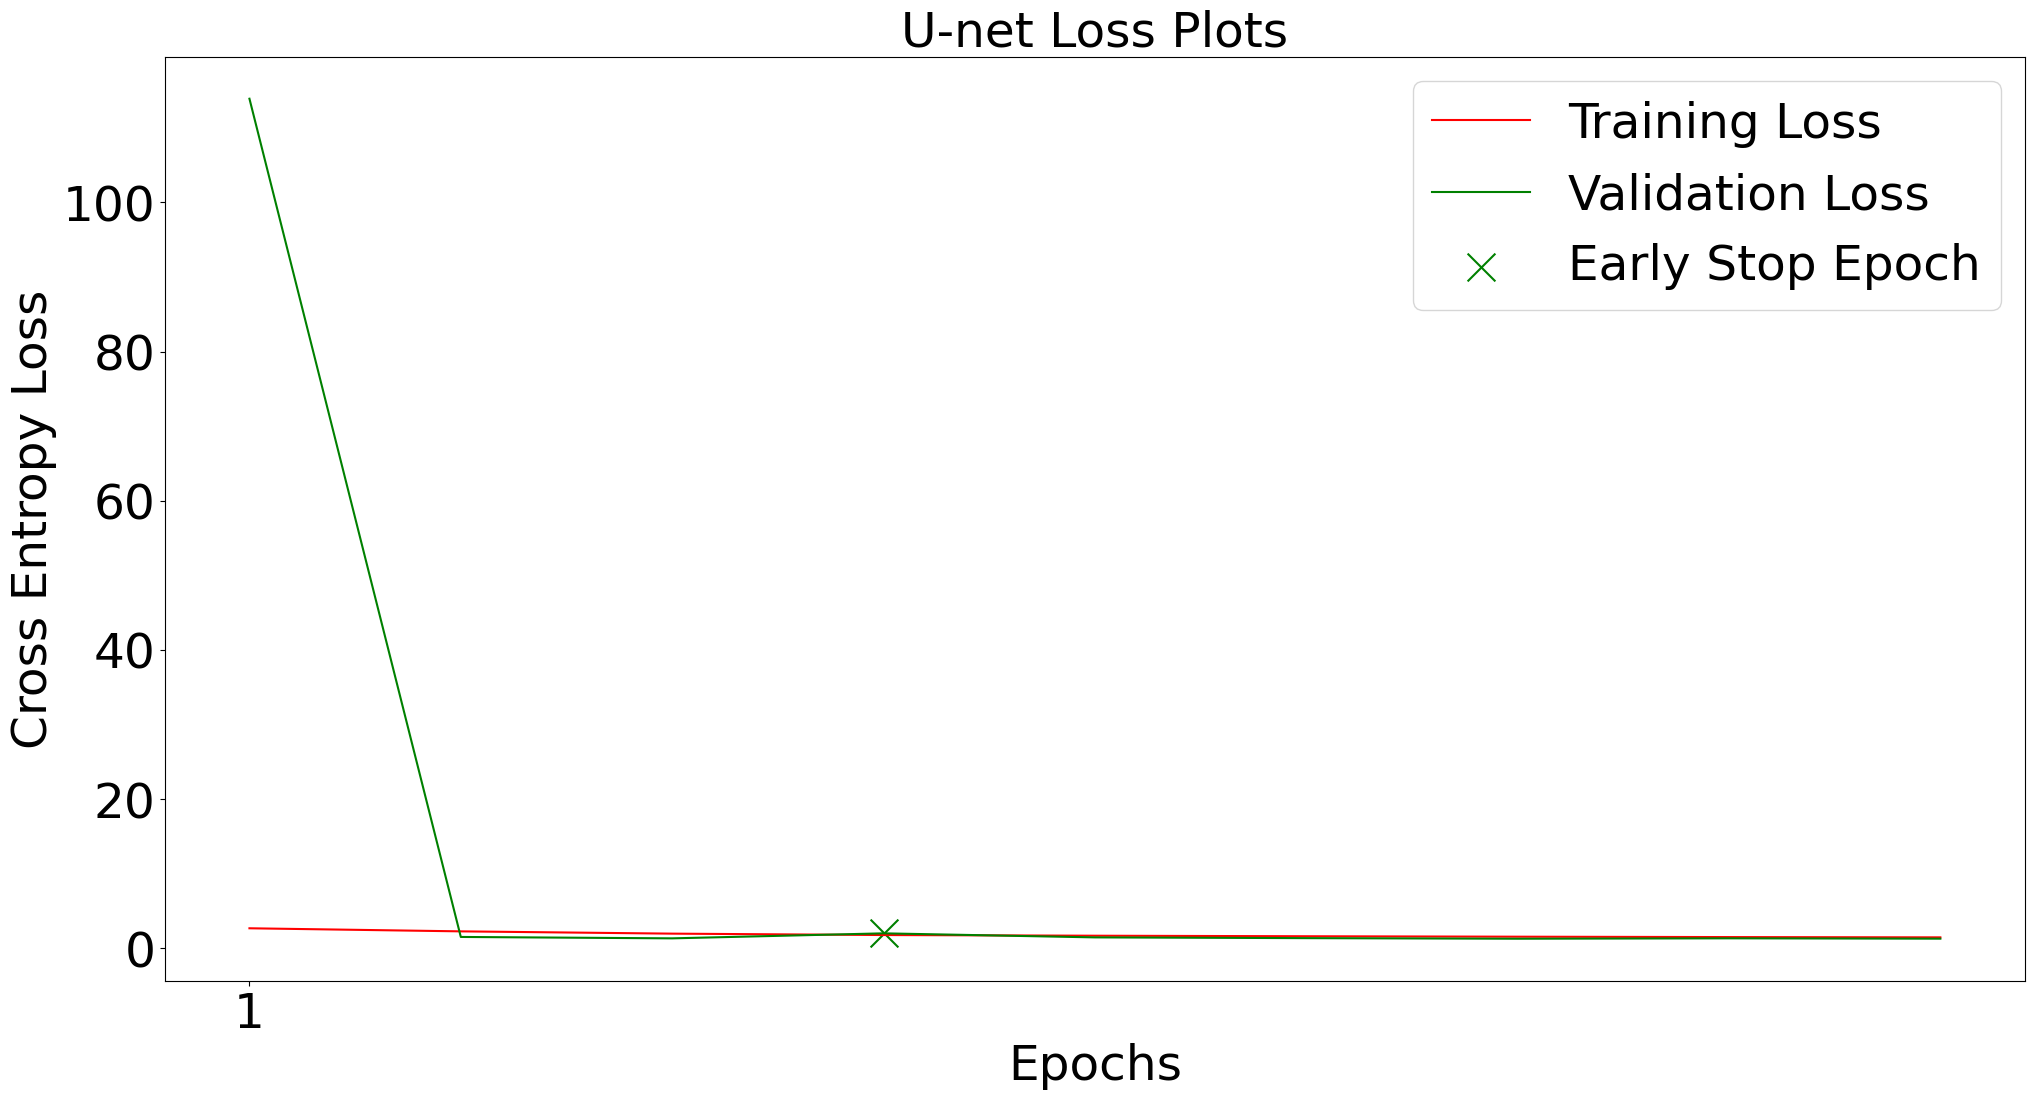

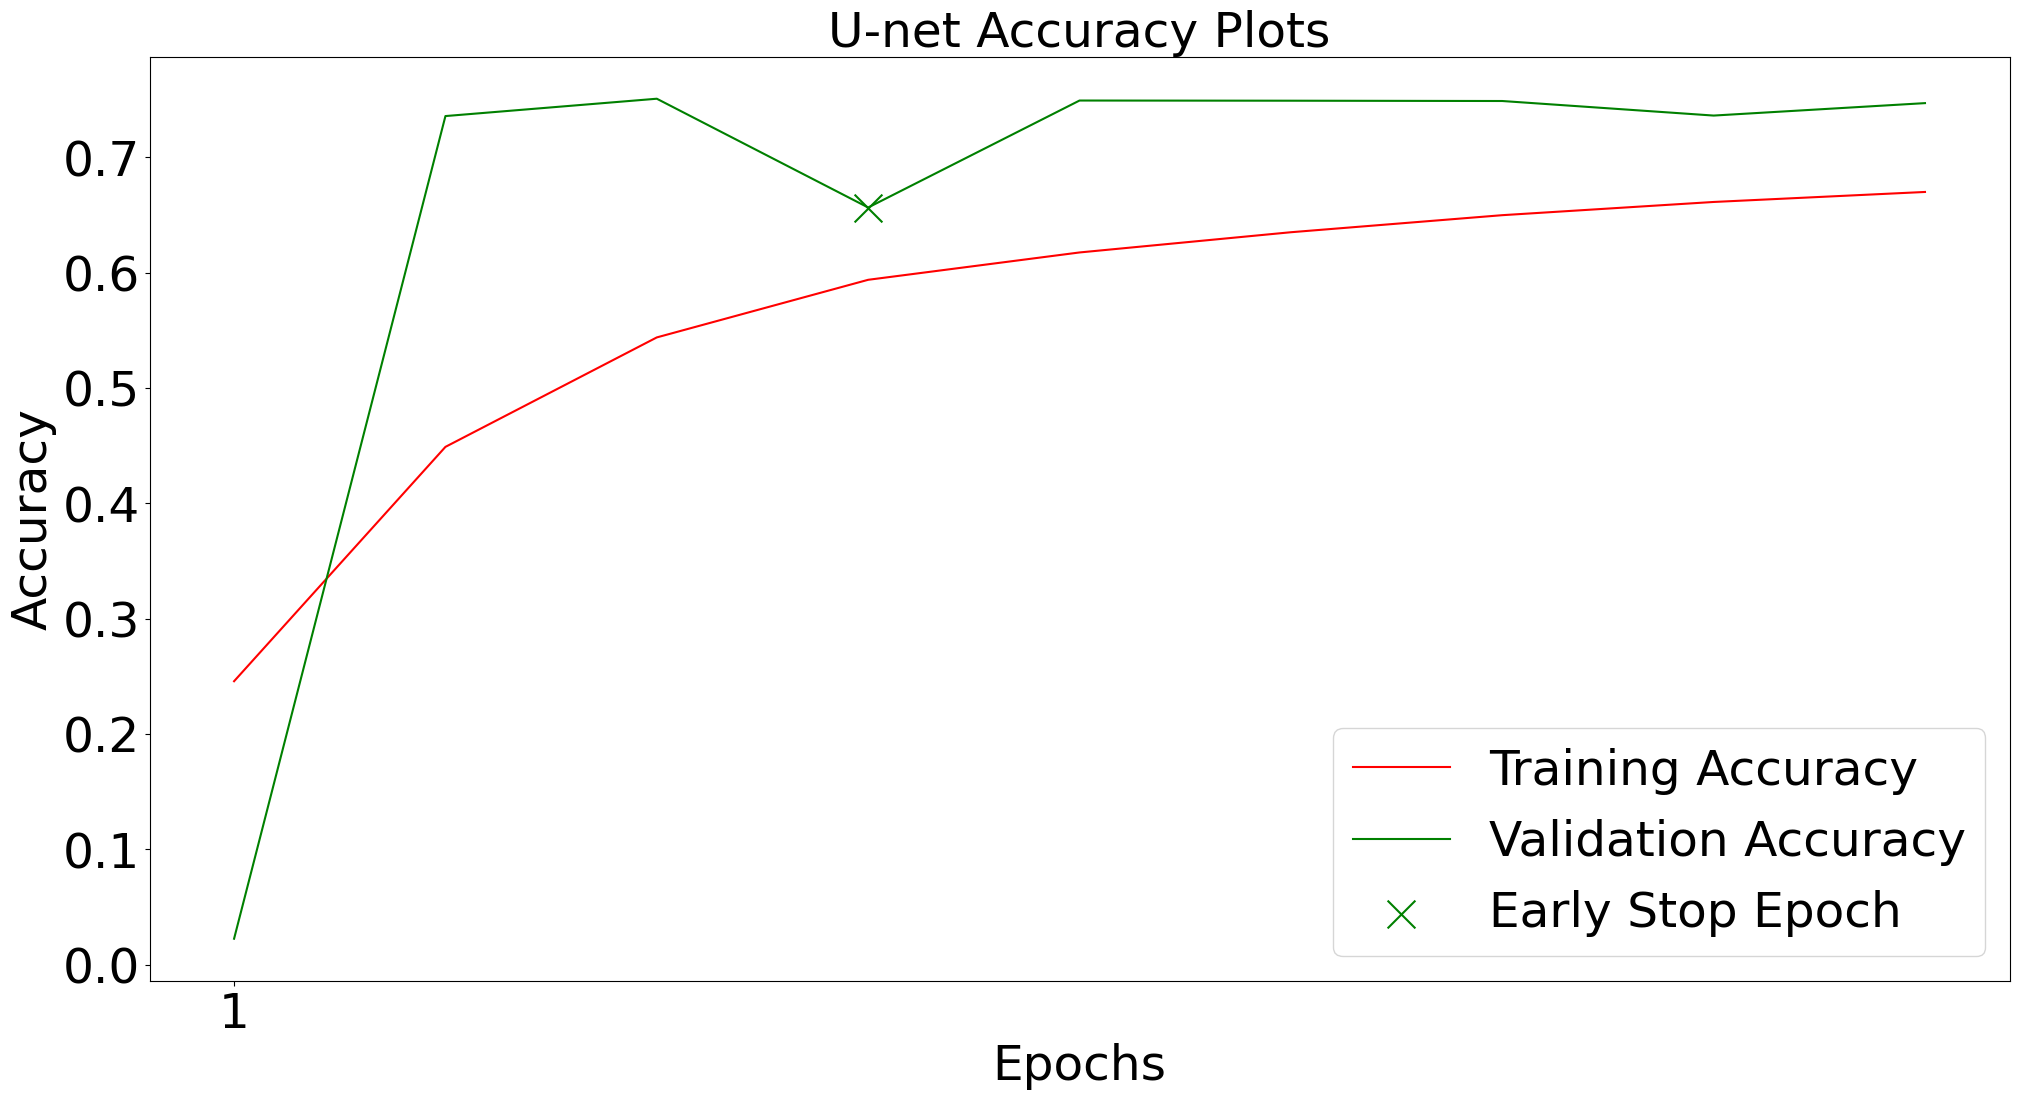

In [ ]:
plots(trainEpochLoss, trainEpochAccuracy, valEpochLoss, valEpochAccuracy, earlystop)

In [ ]:
modelTest()

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.